In [3]:
#This scripts looks at hits below a threshold set and can tell you which panels they are in and then where in each panel 
import sys
import argparse
import math as m
import numpy as np
import matplotlib.pyplot as plt
import re
from matplotlib.colors import LogNorm
from matplotlib.colors import ListedColormap

def c2(a):
    return m.cos(a) * m.cos(a)

def s2(a):
    return m.sin(a) * m.sin(a)

# Return 1/d for hkl in cell, in 1/Angstroms
def resolution(scell, shkl):

    a = float(scell[0])*10.0
    b = float(scell[1])*10.0
    c = float(scell[2])*10.0  # nm -> Angstroms

    al = m.radians(float(scell[3]))
    be = m.radians(float(scell[4]))
    ga = m.radians(float(scell[5])) # in degrees

    h = int(shkl[0])
    k = int(shkl[1])
    l = int(shkl[2])

    pf = 1.0 - c2(al) - c2(be) - c2(ga) + 2.0*m.cos(al)*m.cos(be)*m.cos(ga)
    n1 = h*h*s2(al)/(a*a) + k*k*s2(be)/(b*b) + l*l*s2(ga)/(c*c)
    n2a = 2.0*k*l*(m.cos(be)*m.cos(ga) - m.cos(al))/(b*c)
    n2b = 2.0*l*h*(m.cos(ga)*m.cos(al) - m.cos(be))/(c*a)
    n2c = 2.0*h*k*(m.cos(al)*m.cos(be) - m.cos(ga))/(a*b)

    return m.sqrt((n1 + n2a + n2b + n2c) / pf)

In [4]:
f = open("corrected_48_49_50.stream")


In [5]:
######EXTRACTS PEAKS FROM PEAK FINDER##### indexing is at bottom of workbook
data = []
n=0
in_list = 0
cell = []
data_2 =[]
for line in f:
    if line.find("Reflections measured after indexing") != -1:
        in_list = 1
        continue
    if line.find("End of reflections") != -1:
        in_list = 0
    if in_list == 1:
        in_list = 2
        continue
    elif in_list != 2:
        continue

    # From here, we are definitely handling a reflection line
    # Add reflection to list
    columns = line.split()
    
    n += 1
    
    try:
        data.append(columns)
    except:
        print("Error with line: "+line.rstrip("\r\n"))
        print("Cell: "+str(cell))

       
data_2 = np.asarray(data)
print(np.shape(data_2))
print(data_2)

(12993834, 10)
[['-21' '-27' '-17' ... '230.5' '181.4' 'p12a13']
 ['-21' '-24' '-22' ... '135.2' '241.7' 'p15a15']
 ['-21' '-22' '-22' ... '146.4' '209.5' 'p15a14']
 ...
 ['47' '1' '8' ... '28.2' '57.9' 'p6a6']
 ['48' '1' '8' ... '18.3' '41.6' 'p6a6']
 ['49' '2' '8' ... '17.9' '20.9' 'p6a7']]


In [6]:
# Function to extract the panel data just run once
data=data_2

def extract_number(text):
    # Regular expression pattern to extract the number between 'p' and 'a'
    pattern = r'p(\d+)a'
    
    # Use re.search to find the pattern in the string
    match = re.search(pattern, text)
    
    # Check if a match was found
    if match:
        # Extract the number between 'p' and 'a' (group 1)
        extracted_number = match.group(1)
        # Convert the extracted number to an integer
        extracted_number = int(extracted_number)
        return extracted_number
    else:
        return None

# Apply the extraction function to the last column of each row in the data
extracted_numbers = [extract_number(row[-1]) if 'p' in row[-1] else None for row in data]

# Convert the list to a numpy array
extracted_numbers = np.array(extracted_numbers)

# Replace the last column in each row of the data with the extracted numbers
for i in range(len(data)):
    if 'p' in data[i][-1]:
        data[i][-1] = str(extracted_numbers[i])  # Convert the extracted number back to a string

new_data_set = data
# Convert all elements to float
new_data_set = new_data_set.astype(float)
# Round down each element to the nearest integer
rounded_data_set = np.floor(new_data_set)
rounded_data_set =rounded_data_set[0:-1,:]
max_values = np.max(rounded_data_set, axis=0)
min_values = np.min(rounded_data_set, axis=0)
print(max_values)
print(min_values)
print(rounded_data_set)

[5.80000e+01 5.80000e+01 2.80000e+01 3.98376e+05 6.43050e+04 3.88786e+05
 8.34800e+03 2.53000e+02 2.53000e+02 1.50000e+01]
[-5.8000e+01 -5.8000e+01 -2.8000e+01 -3.7285e+04  5.0000e+00 -2.7000e+01
 -3.3300e+02  3.0000e+00  3.0000e+00  0.0000e+00]
[[-21. -27. -17. ... 230. 181.  12.]
 [-21. -24. -22. ... 135. 241.  15.]
 [-21. -22. -22. ... 146. 209.  15.]
 ...
 [ 46.   0.   8. ...  28.  76.   6.]
 [ 47.   1.   8. ...  28.  57.   6.]
 [ 48.   1.   8. ...  18.  41.   6.]]


In [7]:
rounded_data_set_cat =rounded_data_set[:,5:10]
print(np.shape(rounded_data_set_cat))


(12993833, 5)


In [8]:
#Selecting specific area of interest with intenisty 
# Create a boolean mask where the first column is between 120 and 300
mask = (rounded_data_set_cat[:, 0] >= 0) & (rounded_data_set_cat[:, 0] <= 18)

# Apply the mask to get a new array with only the rows that satisfy the condition
filtered_array = rounded_data_set_cat[mask]
rounded_data_set_cat= filtered_array[:,2:5]

In [9]:
print(rounded_data_set_cat)

[[168.  26.  11.]
 [ 18. 186.  15.]
 [ 12. 184.  15.]
 ...
 [241. 174.  15.]
 [249. 116.  10.]
 [ 70. 197.   4.]]


0
new_mask[ 0 , 74 , 233 ]=0
new_mask[ 0 , 198 , 244 ]=0
new_mask[ 0 , 204 , 216 ]=0
3
new_mask[ 3 , 3 , 27 ]=0
new_mask[ 3 , 3 , 28 ]=0
new_mask[ 3 , 5 , 28 ]=0
new_mask[ 3 , 7 , 27 ]=0
new_mask[ 3 , 8 , 27 ]=0
new_mask[ 3 , 8 , 28 ]=0
new_mask[ 3 , 9 , 27 ]=0
new_mask[ 3 , 9 , 28 ]=0
new_mask[ 3 , 10 , 27 ]=0
new_mask[ 3 , 10 , 28 ]=0
new_mask[ 3 , 11 , 27 ]=0
new_mask[ 3 , 11 , 28 ]=0
new_mask[ 3 , 12 , 25 ]=0
new_mask[ 3 , 12 , 26 ]=0
new_mask[ 3 , 12 , 28 ]=0
12
new_mask[ 12 , 140 , 35 ]=0
new_mask[ 12 , 140 , 36 ]=0
new_mask[ 12 , 140 , 37 ]=0
new_mask[ 12 , 140 , 38 ]=0
new_mask[ 12 , 140 , 39 ]=0
new_mask[ 12 , 140 , 42 ]=0
new_mask[ 12 , 140 , 43 ]=0
new_mask[ 12 , 140 , 44 ]=0
new_mask[ 12 , 140 , 45 ]=0
new_mask[ 12 , 140 , 46 ]=0
15
new_mask[ 15 , 5 , 171 ]=0
new_mask[ 15 , 7 , 174 ]=0
new_mask[ 15 , 7 , 181 ]=0
new_mask[ 15 , 10 , 183 ]=0
new_mask[ 15 , 11 , 176 ]=0
new_mask[ 15 , 11 , 184 ]=0
new_mask[ 15 , 12 , 174 ]=0
new_mask[ 15 , 12 , 179 ]=0
new_mask[ 15 , 14 , 177 

NameError: name 'Circle' is not defined

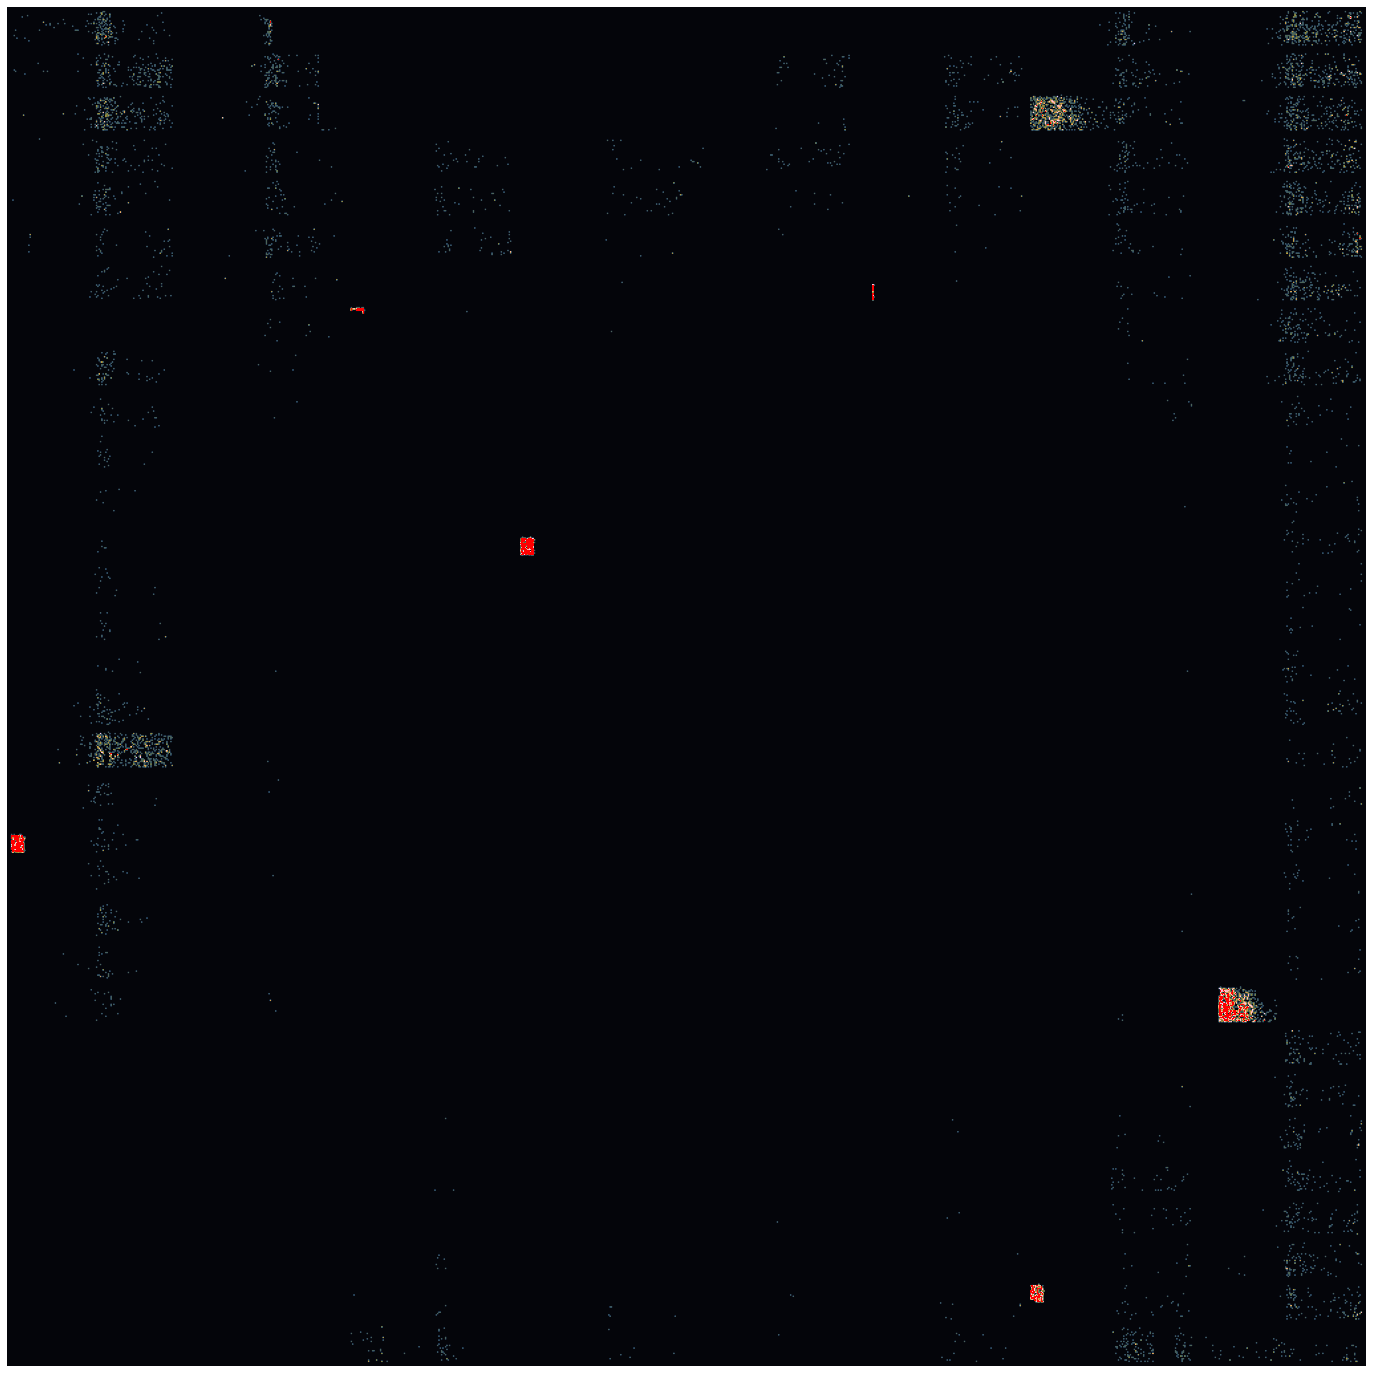

In [10]:
# Create a blank canvas for the combined image
combined_image = np.zeros([1024, 1024])
vmax =3

order = [0,3,12,15,1,2,13,14,4,7,8,11,5,6,9,10]

# Define the number of rows and columns for the panels
num_rows = 4
num_cols = 4

# Initialize variables for row and column
current_row = 0
current_col = 0


for Panel_no in order:
    print(Panel_no)
    pixel_marker = np.zeros([256, 256])
    [data_shape, data_shape_1] = np.shape(rounded_data_set_cat)

    for idx in range(0, data_shape):
        [i, j, k] = rounded_data_set_cat[idx, :]
        if int(k) == Panel_no:
            pixel_marker[int(round(i)), int(round(j))] += 1
    for i in range(256):
        for j in range(256):
            if pixel_marker[i, j] > vmax:
                #print({Panel_no}: i={i}, j={j}")
                print(f"new_mask[",Panel_no,",",i,",",j,"]=0")
    
    pixel_marker
    #Rotate pixel marker
    pixel_marker = np.rot90(pixel_marker, k=1)

    # Calculate the position based on the current row and column
    row = current_row * 256
    col = current_col * 256

    # Update the current row and column
    current_col += 1
    if current_col == num_cols:
        current_col = 0
        current_row += 1

    # Assign the pixel_marker to the appropriate location in the combined image
    combined_image[row:row+256, col:col+256] = pixel_marker

colors = np.loadtxt('batlow.txt')
batlow_cmap = plt.cm.colors.ListedColormap(colors)

batlow_cmap.set_over('red')

plt.figure(figsize=(25, 25))
ax = plt.gca()

# Display the combined image
im = ax.imshow(combined_image, cmap=batlow_cmap, vmin=0, vmax=vmax)
plt.axis('off')

# Iterate over the combined_image to highlight pixels over vmax
for (i, j), value in np.ndenumerate(combined_image):
    if value > vmax:
        # Add a circle at (j, i)
        circle = Circle((j, i), radius=2, color='red', fill=False)
        ax.add_patch(circle)
        #print(f"new_mask[",Panel_no,",",i,",",j,"]=0")

# Optionally, add a colorbar to show the mapping from data values to colors.
# cbar = plt.colorbar(im, extend='max')
# cbar.ax.set_ylabel('Intensity')

# Display the number of pixels above vmax
num_pixels_above_vmax = np.sum(combined_image > vmax)
print(f"Number of pixels above vmax ({vmax}):", num_pixels_above_vmax)

plt.show()
    
    

In [51]:
#Where are peaks in the panel??? Change panel number to look at specific panel or run next box to view all panels. Vmax is threshold, how many times peaks found for each pixel
%matplotlib inline
Panel_no = 4
vmax =1

pixel_marker = np.zeros([256,256])
[data_shape,data_shape_1] = np.shape(rounded_data_set_cat)
for idx in range(0,(data_shape)):
    [i,j,k] = rounded_data_set_cat[idx,:]
    if int(k) == Panel_no:
        pixel_marker[int(round(i)),int(round(j))] = pixel_marker[int(round(i)),int(round(j))] + 1


for i in range(0,256):
    for j in range(0,256):
        if pixel_marker[i,j]>vmax:
            #print(i , j)
            #print(f"new_mask[",Panel_no,",",i,",",j,"]=0")  
            
            plt.rcParams['figure.figsize']=[50,50]
cmap = plt.get_cmap('viridis')
cmap.set_over('red')
plt.matshow(pixel_marker, cmap=cmap, vmin=0, vmax=vmax)
cbar = plt.colorbar(extend='max')
plt.title('Peakfinder peaks in Panel ' +str(Panel_no))
plt.show


ValueError: too many values to unpack (expected 3)

In [26]:
rounded_data_set_cat =rounded_data_set[:,5:10]
mask = (rounded_data_set_cat[:, 0] >= 20) & (rounded_data_set_cat[:, 0] <= 120)

# Apply the mask to get a new array with only the rows that satisfy the condition
rounded_data_set_cat = rounded_data_set_cat[mask]
print(np.shape(rounded_data_set_cat))

(522507, 5)


0
3
12
15
1
2
13
14
4
7
8
11
5
6
9
10


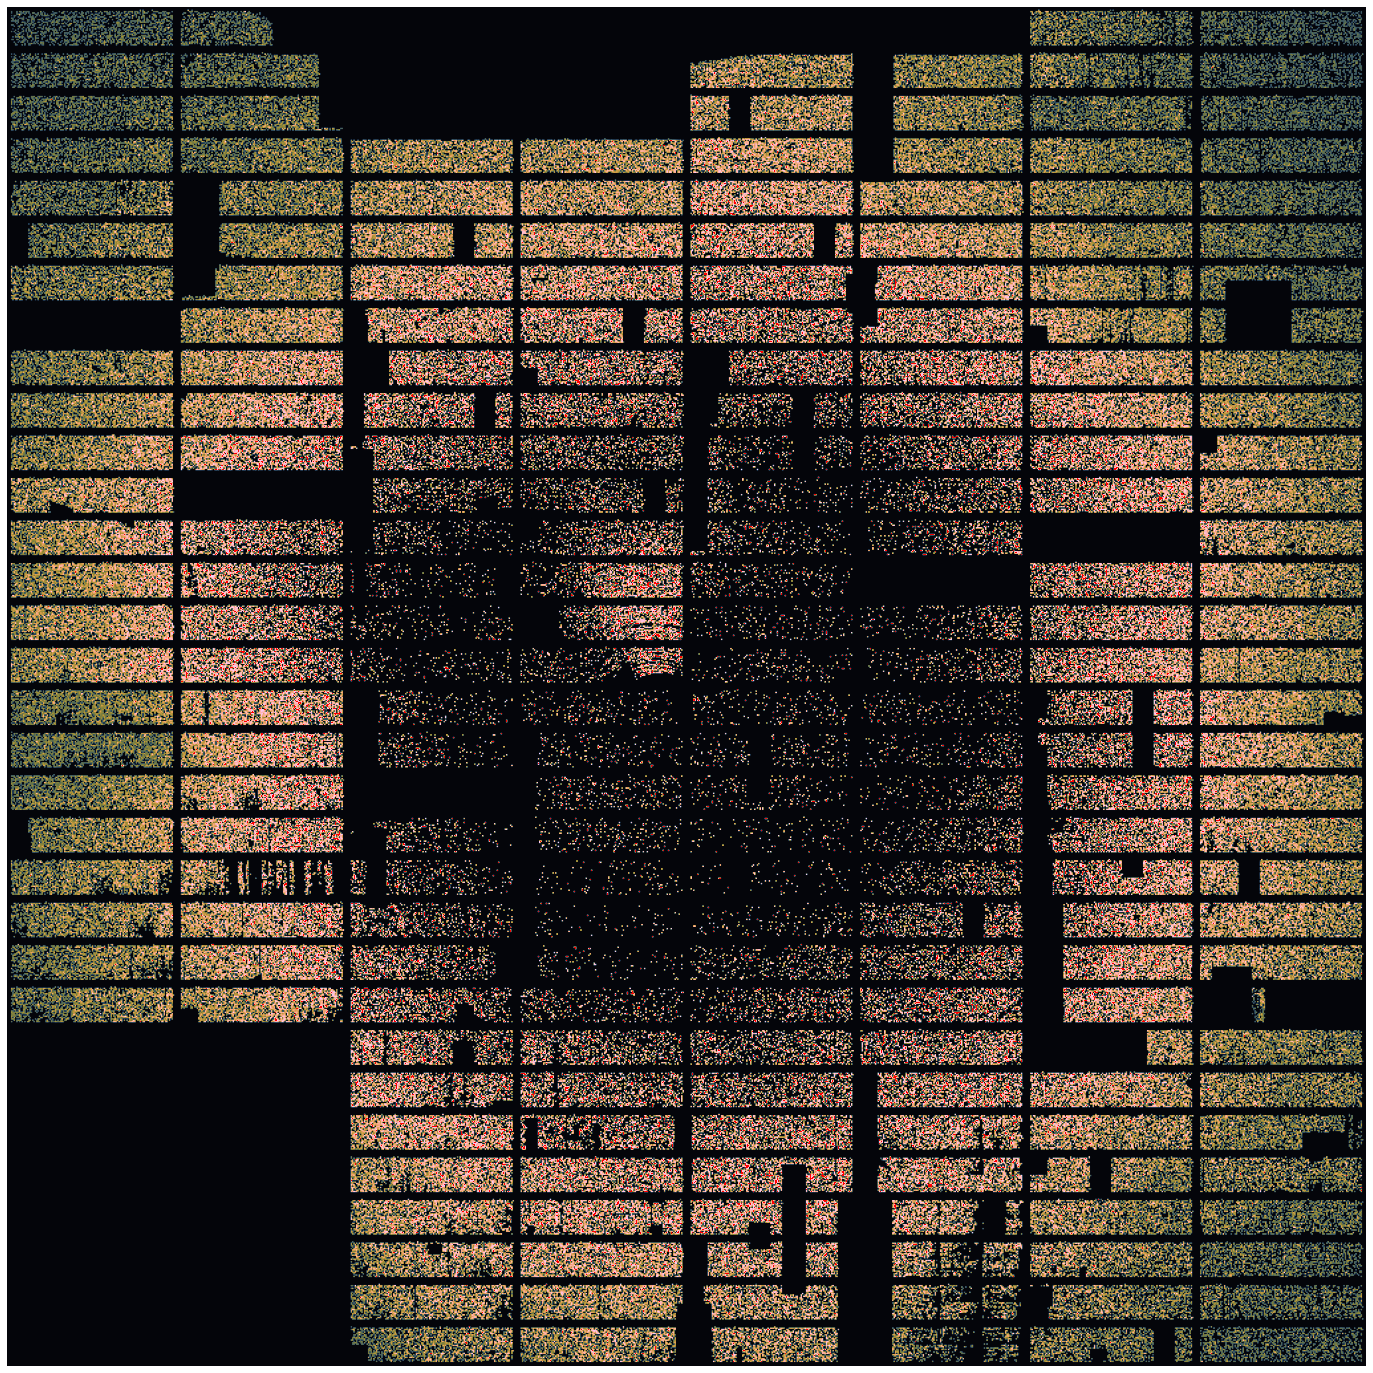

In [58]:

# Create a blank canvas for the combined image
combined_image = np.zeros([1024, 1024])
vmax = 100

order = [0, 3, 12, 15, 1, 2, 13, 14, 4, 7, 8, 11, 5, 6, 9, 10]

# Define the number of rows and columns for the panels
num_rows = 4
num_cols = 4

# Initialize variables for row and column
current_row = 0
current_col = 0



for Panel_no in order:
    pixel_peak_sum = np.zeros([256, 256])
    pixel_count = np.zeros([256, 256])
    print(Panel_no)
    pixel_marker = np.zeros([256, 256])
    [data_shape, data_shape_1] = np.shape(rounded_data_set_cat)

    for idx in range(0, data_shape):
        [peak, f, i, j, k] = rounded_data_set_cat[idx, :]
        if int(k) == Panel_no:
            pixel_peak_sum[int(round(i)), int(round(j))] += peak
            pixel_count[int(round(i)), int(round(j))] += 1
            if int(k) == [13,2,7,8]:
                pixel_peak_sum[int(round(i)), int(round(j))] ==0
    pixel_count = np.rot90(pixel_count, k=1)
    pixel_peak_sum = np.rot90(pixel_peak_sum, k=1)
    # Calculate the position based on the current row and column
    row = current_row * 256
    col = current_col * 256
    
    # Update the current row and column
    current_col += 1
    if current_col == num_cols:
        current_col = 0
        current_row += 1

    # Assign the pixel_marker to the appropriate location in the combined image
    average_pixel_peak = np.where(pixel_count > 0, pixel_peak_sum / pixel_count, 0)
    combined_image[row:row + 256, col:col + 256] = average_pixel_peak
    pixel_count = np.rot90(pixel_count, k=1)
colors = np.loadtxt('batlow.txt')
batlow_cmap = plt.cm.colors.ListedColormap(colors)

batlow_cmap.set_over('red')

plt.figure(figsize=(25, 25))
ax = plt.gca()

# Display the combined image
im = ax.imshow(combined_image, cmap=batlow_cmap, vmin=0, vmax=vmax)
plt.axis('off')

plt.show()


0
3
12
15
1
2
13
14
4
7
8
11
5
6
9
10


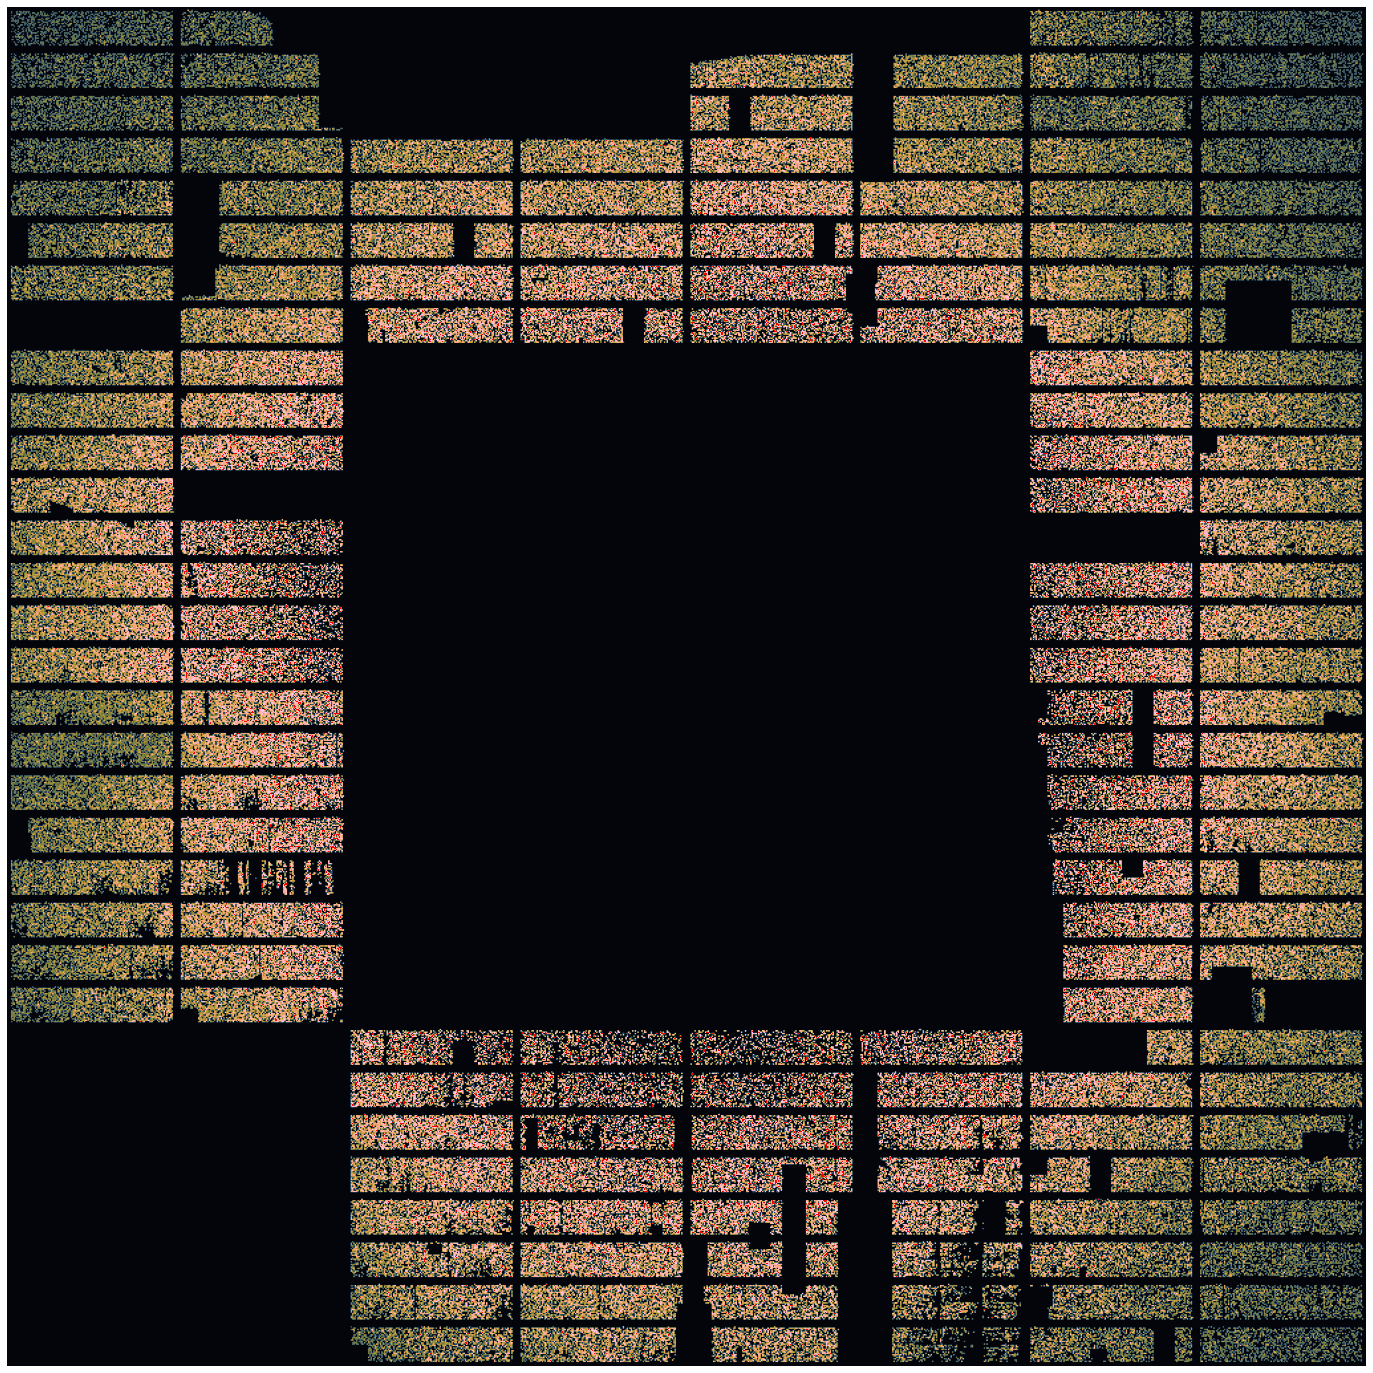

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

# Create a blank canvas for the combined image
combined_image = np.zeros([1024, 1024])
vmax = 100

order = [0, 3, 12, 15, 1, 2, 13, 14, 4, 7, 8, 11, 5, 6, 9, 10]

# Define the number of rows and columns for the panels
num_rows = 4
num_cols = 4

# Initialize variables for row and column
current_row = 0
current_col = 0

for Panel_no in order:
    pixel_peak_sum = np.zeros([256, 256])
    pixel_count = np.zeros([256, 256])
    print(Panel_no)
    pixel_marker = np.zeros([256, 256])
    [data_shape, data_shape_1] = np.shape(rounded_data_set_cat)

    for idx in range(0, data_shape):
        [peak, f, i, j, k] = rounded_data_set_cat[idx, :]
        if int(k) == Panel_no and int(k) not in [13, 2, 7, 8]:
            pixel_peak_sum[int(round(i)), int(round(j))] += peak
            pixel_count[int(round(i)), int(round(j))] += 1

    pixel_count = np.rot90(pixel_count, k=1)
    pixel_peak_sum = np.rot90(pixel_peak_sum, k=1)
    
    # Calculate the position based on the current row and column
    row = current_row * 256
    col = current_col * 256

    # Update the current row and column
    current_col += 1
    if current_col == num_cols:
        current_col = 0
        current_row += 1

    # Assign the pixel_marker to the appropriate location in the combined image
    average_pixel_peak = np.where(pixel_count > 0, pixel_peak_sum / pixel_count, 0)
    combined_image[row:row + 256, col:col + 256] = average_pixel_peak
    pixel_count = np.rot90(pixel_count, k=1)

colors = np.loadtxt('batlow.txt')
batlow_cmap = plt.cm.colors.ListedColormap(colors)

batlow_cmap.set_over('red')

plt.figure(figsize=(25, 25))
ax = plt.gca()

# Display the combined image
im = ax.imshow(combined_image, cmap=batlow_cmap, vmin=0, vmax=vmax)
plt.axis('off')

plt.show()



<function matplotlib.pyplot.show(close=None, block=None)>

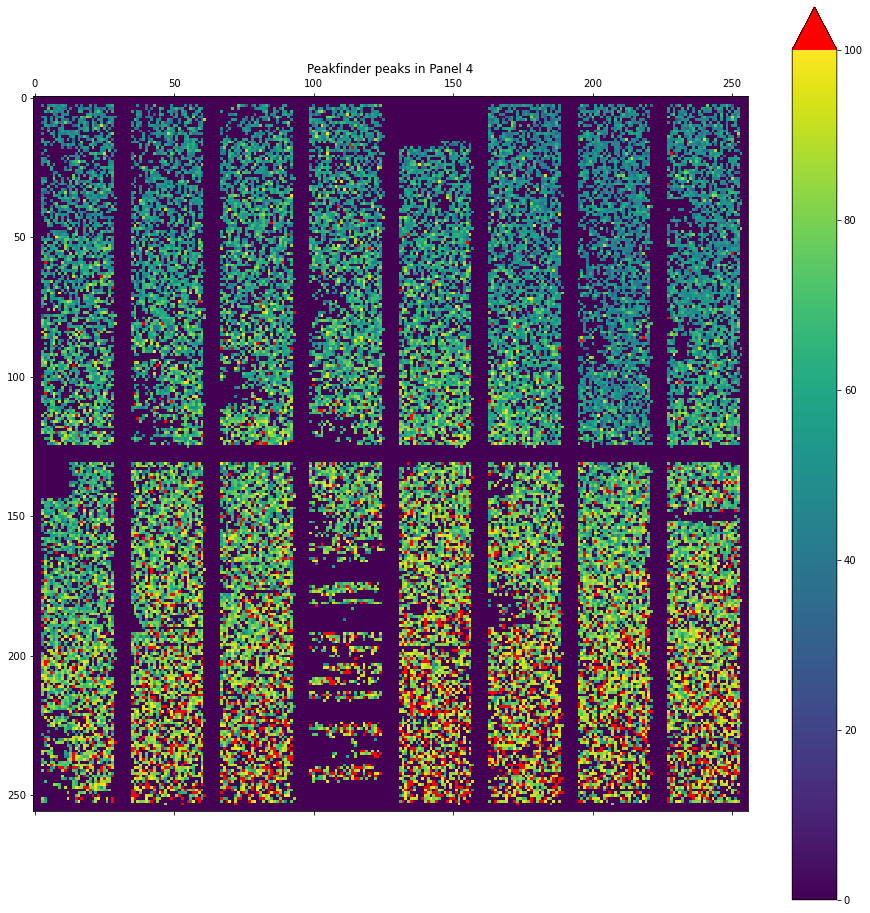

In [54]:

%matplotlib inline
Panel_no = 4
vmax =100
pixel_peak_sum = np.zeros([256, 256])
pixel_count = np.zeros([256, 256])
pixel_marker = np.zeros([256,256])
[data_shape,data_shape_1] = np.shape(rounded_data_set_cat)
for idx in range(0,(data_shape)):
    [peak, f, i, j, k] = rounded_data_set_cat[idx,:]
    if int(k) == Panel_no:

        pixel_peak_sum[int(round(i)), int(round(j))] += peak
        pixel_count[int(round(i)), int(round(j))] += 1

average_pixel_peak = np.where(pixel_count > 0, pixel_peak_sum / pixel_count, 0)
plt.rcParams['figure.figsize']=[50,50]
cmap = plt.get_cmap('viridis')
cmap.set_over('red')
plt.matshow(average_pixel_peak, cmap=cmap, vmin=0, vmax=vmax)
cbar = plt.colorbar(extend='max')
plt.title('Peakfinder peaks in Panel ' +str(Panel_no))
plt.show
